In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import sklearn
from tensorflow.keras.datasets import mnist
import torch.nn as nn
import torch.nn.functional as F
import torch 
(x_train, y_train), (x_test, y_test) = mnist.load_data()


[2.640e+02 1.600e+01 7.040e+02 7.400e+01 1.170e+02 9.000e+01 4.597e+03
 3.000e+00 2.500e+01 5.000e+00]
[  34. 6538.  686.  503.  467.  395.  474.  440. 1056.  303.]
[  6.   0.  27.  77. 253.  52.   5. 794.  61. 352.]
[3139.    0.   24.    9.   38.   24.  245.   17.   38.   36.]
[  11.    8.  177.  187. 3337.  266.   18. 1315.  278. 2871.]
[7.00e+00 7.00e+00 2.70e+01 7.60e+01 7.24e+02 6.80e+01 1.00e+00 3.53e+03
 1.64e+02 2.13e+03]
[ 105.   11. 2061.  650.   78.  236.  376.   12.  193.   19.]
[ 246.  133.   42.   81.  791. 2242.   74.  133. 1752.  113.]
[ 903.    8. 1613. 1009.   33.  197.   33.   11.  108.   10.]
[1208.   21.  597. 3465.    4. 1851.   95.   10. 2176.  110.]
[6, 1, 7, 0, 4, 9, 2, 5, 3, 8]
Cluster 0


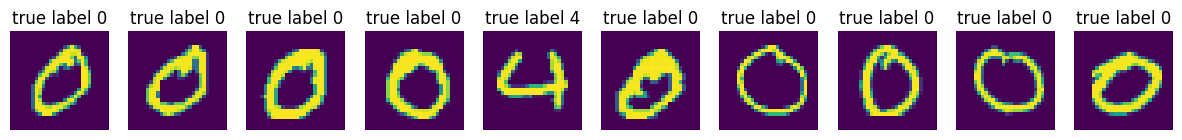

Cluster 1


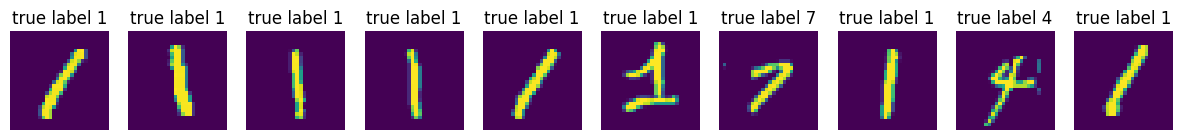

Cluster 2


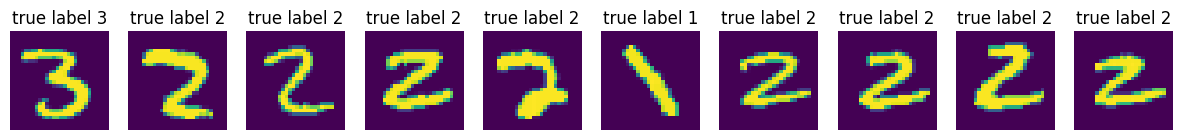

Cluster 3


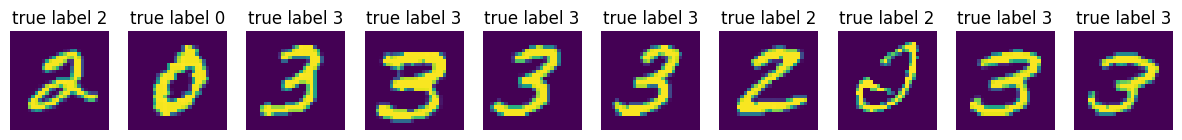

Cluster 4


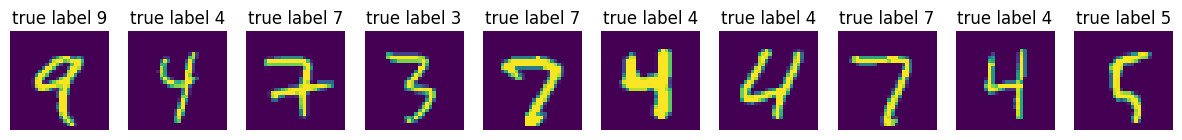

Cluster 5


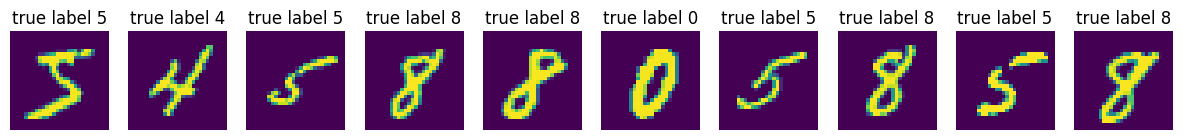

Cluster 6


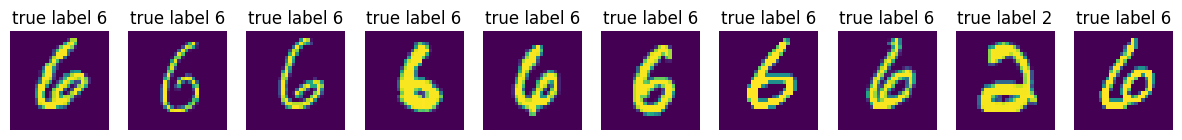

Cluster 7


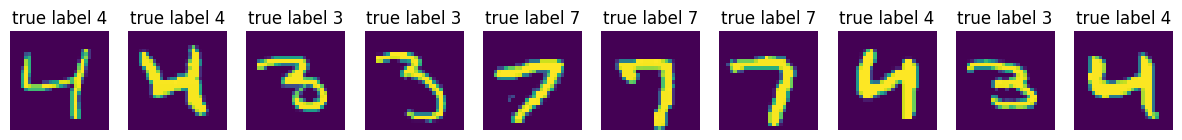

Cluster 8


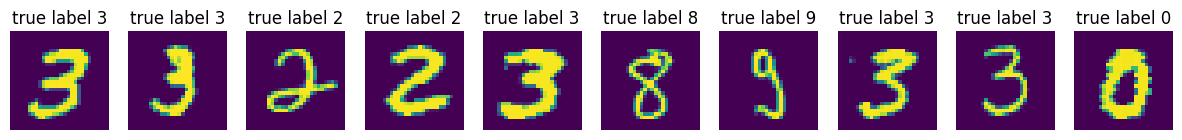

Cluster 9


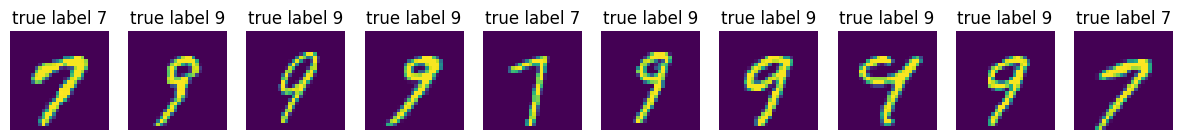

Accuracy: 46.71%
ARI is 31.83%


In [29]:

# Preprocessing: flatten images
import sklearn.metrics


x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

# Use PCA to reduce dimensionality for clustering
pca = PCA(n_components=64)  # Adjust the number of components as needed
x_train_pca = pca.fit_transform(x_train_flat)

def do_k_means(clustering_data):

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    kmeans.fit(clustering_data)
    labels = kmeans.labels_

    # Function to plot some clustered images
    def plot_cluster_examples(images, labels, cluster_num, y_train, n_examples=10):
        cluster_images = images[labels == cluster_num]
        true_labels = y_train[labels == cluster_num]
        fig, axes = plt.subplots(1, n_examples, figsize=(15, 15))
        for i, ax in enumerate(axes):
            if i < len(cluster_images):
                ax.imshow(cluster_images[i])
                ax.set_title(f'true label {true_labels[i]}')
                ax.axis('off')
        plt.show()



    # Evaluating clustering by comparing with true labels
    # Assign each cluster a label based on majority voting
    from scipy.stats import mode

    def counts(list):
        counts = np.zeros(10)
        for i in range(len(list)):
            for c in range(10):
                if(list[i] ==c ):
                    counts[c]+=1
        return counts

            

    def assign_labels(kmeans_labels, true_labels):
        assigned_labels = np.zeros_like(kmeans_labels)
        labels_used = []
        for i in range(10):  # assuming 10 clusters
            mask = (kmeans_labels == i)
            #take mode to of true labels in cluster 
            modes = counts(true_labels[mask])
            common_label = np.argmax(modes)
            print(modes)
            
            while common_label in labels_used:
                #set label to zero to remove it from argmax consideration 
                modes[common_label] = 0
                common_label = np.argmax(modes)

                    
            assigned_labels[mask] = common_label
            labels_used.append(common_label)
        print(labels_used)
        return assigned_labels

    # Assign labels and calculate accuracy
    predicted_labels = assign_labels(labels, y_train.flatten())


    # Plot examples from each cluster
    for cluster in range(10):
        print(f"Cluster {cluster}")
        plot_cluster_examples(x_train, predicted_labels, cluster, y_train)

    ARI = sklearn.metrics.adjusted_rand_score(y_train.flatten(), predicted_labels)

    accuracy = np.mean(predicted_labels == y_train.flatten())
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f'ARI is {ARI * 100:.2f}%')

do_k_means(x_train_flat)


In [5]:
#TODO figure out what to do about missing classes 

print(x_train_flat.shape )

(60000, 784)


In [10]:


# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, encoding_dim)
        )
        ## decoder ##
        self.decoder =   self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.Tanh(),
            nn.Linear(32, 128),
            nn.Tanh(),
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512,784),
            nn.Sigmoid()
        )

    def forward(self, x):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = F.relu(self.encoder(x))
        # pass out into decoder
        out = self.decoder(out)
        
        return out
    
    def encode(self, x ):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        return self.encoder(x)

# initialize the NN
encoding_dim = 10
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


Cluster 0


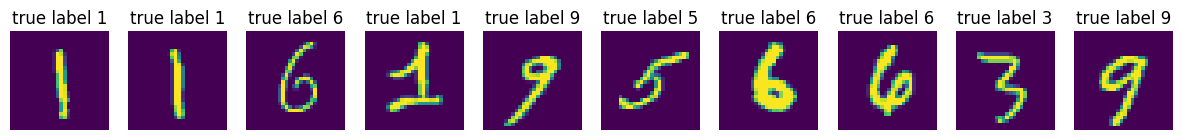

Cluster 1


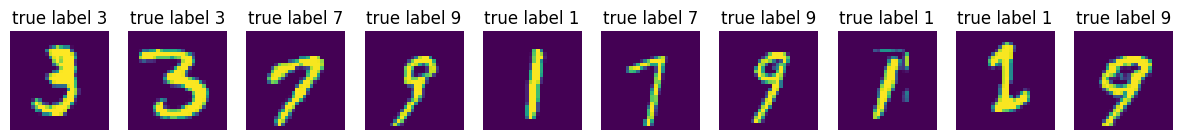

Cluster 2


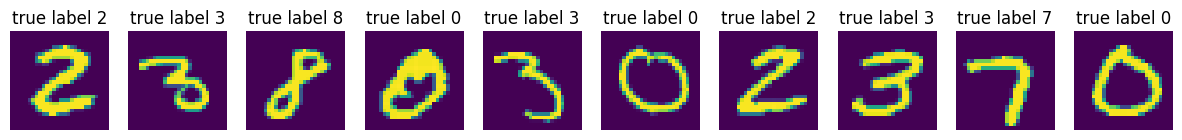

Cluster 3


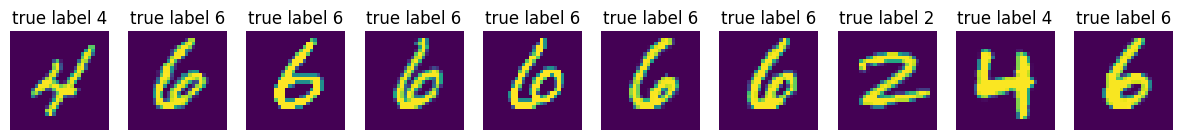

Cluster 4


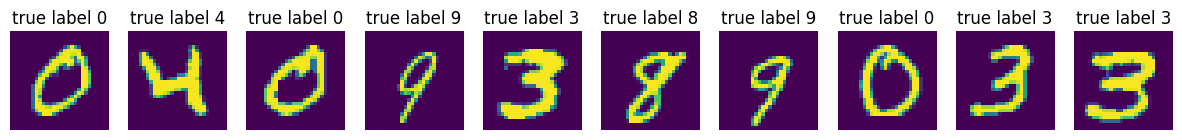

Cluster 5


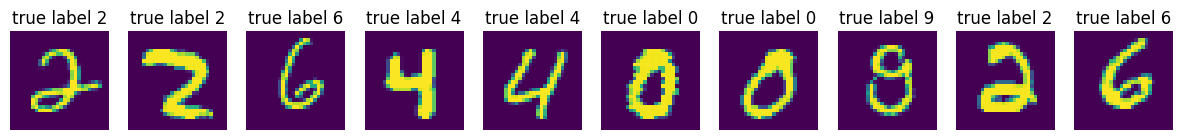

Cluster 6


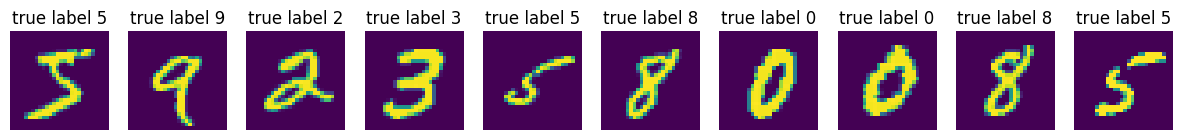

Cluster 7


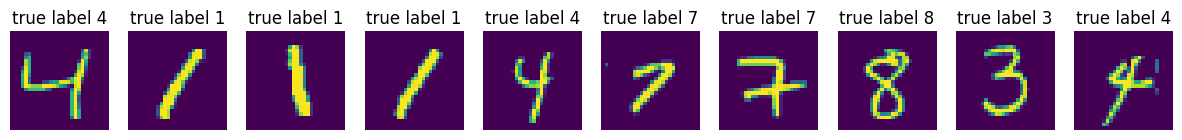

Cluster 8


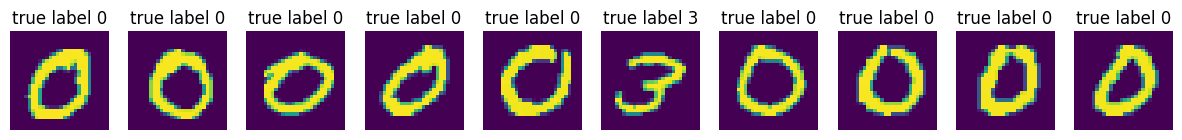

Cluster 9


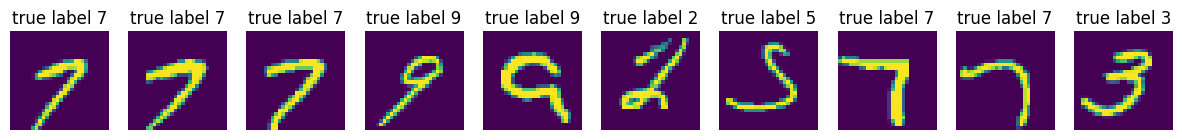

Accuracy: 27.25%


In [11]:
#Untrained model
x_train_encoder = model.encode(x_train_flat)
x_train_encoder.shape
do_k_means(x_train_encoder.detach().numpy())

In [13]:
trained_model = Autoencoder(encoding_dim)
batched_data = np.reshape(x_train_flat, (3000, 20, 784))
print(batched_data.shape)
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in batched_data:
        images = torch.tensor(data, dtype=torch.float32)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = trained_model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(batched_data)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

(3000, 20, 784)
Epoch: 1 	Training Loss: 14.451276
Epoch: 2 	Training Loss: 13.799561
Epoch: 3 	Training Loss: 13.691765
Epoch: 4 	Training Loss: 13.643237
Epoch: 5 	Training Loss: 13.606343
Epoch: 6 	Training Loss: 13.583822
Epoch: 7 	Training Loss: 13.569119
Epoch: 8 	Training Loss: 13.549038
Epoch: 9 	Training Loss: 13.542074
Epoch: 10 	Training Loss: 13.532703
Epoch: 11 	Training Loss: 13.545538
Epoch: 12 	Training Loss: 13.526338
Epoch: 13 	Training Loss: 13.531671
Epoch: 14 	Training Loss: 13.514707
Epoch: 15 	Training Loss: 13.526654
Epoch: 16 	Training Loss: 13.526054
Epoch: 17 	Training Loss: 13.528538
Epoch: 18 	Training Loss: 13.522710
Epoch: 19 	Training Loss: 13.535438
Epoch: 20 	Training Loss: 13.526060


[ 764. 6644. 2056. 2188. 3976. 1588. 1893. 1566. 3469. 3037.]
[0. 1. 2. 1. 0. 0. 1. 1. 0. 0.]
[1385.   28. 2195. 2336.  278. 1353. 2861.   12.  799.  178.]
[0. 2. 5. 2. 1. 0. 5. 7. 0. 2.]
[2998.    0.  274.   53.   41.  151.  938.   30.   73.   28.]
[1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
[ 675.   52.  775.  789.  272. 1838.   91.  281. 1203.  125.]
[ 77.   8. 548. 654. 134. 315.  68. 509.  89. 247.]
[2.100e+01 3.000e+00 8.200e+01 8.800e+01 1.136e+03 1.560e+02 2.600e+01
 3.744e+03 2.040e+02 2.315e+03]
[  2.   3.  21.  20.   4.  19.  35. 115.  14.  17.]
[1, 2, 6, 7, 0, 5, 8, 3, 9, 4]
Cluster 0


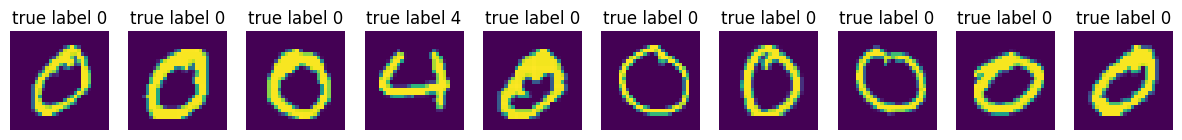

Cluster 1


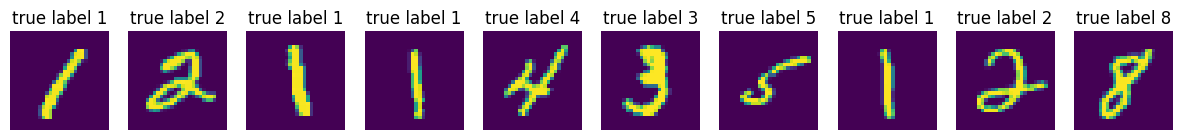

Cluster 2


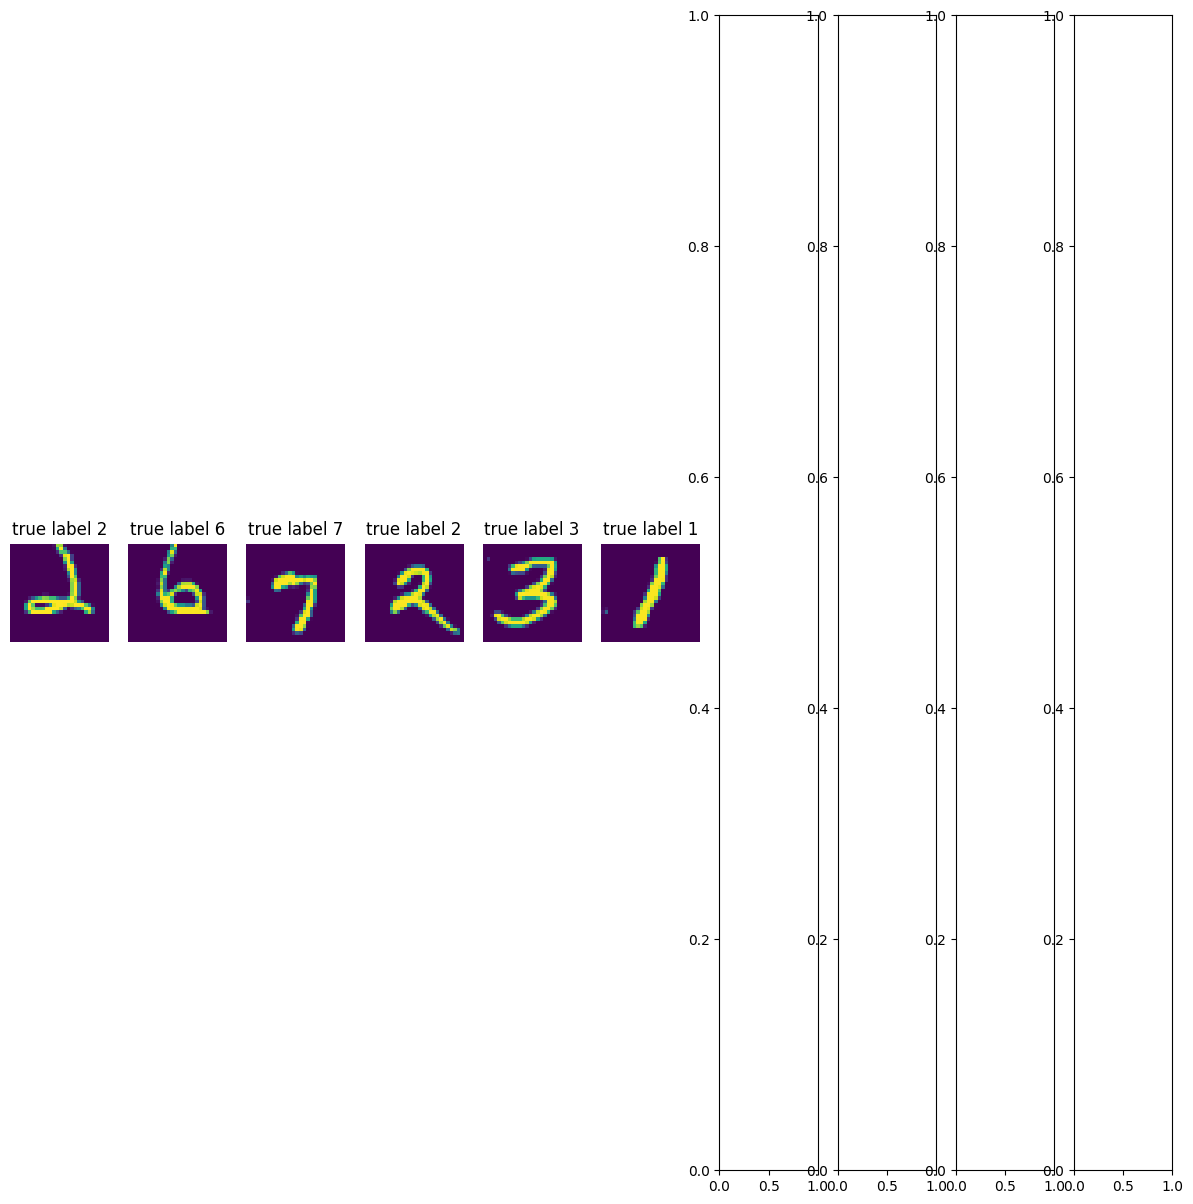

Cluster 3


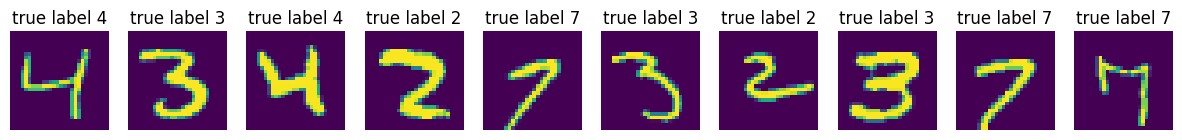

Cluster 4


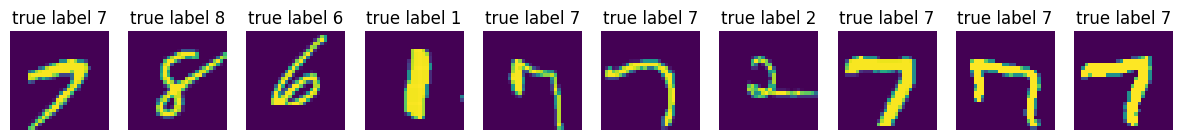

Cluster 5


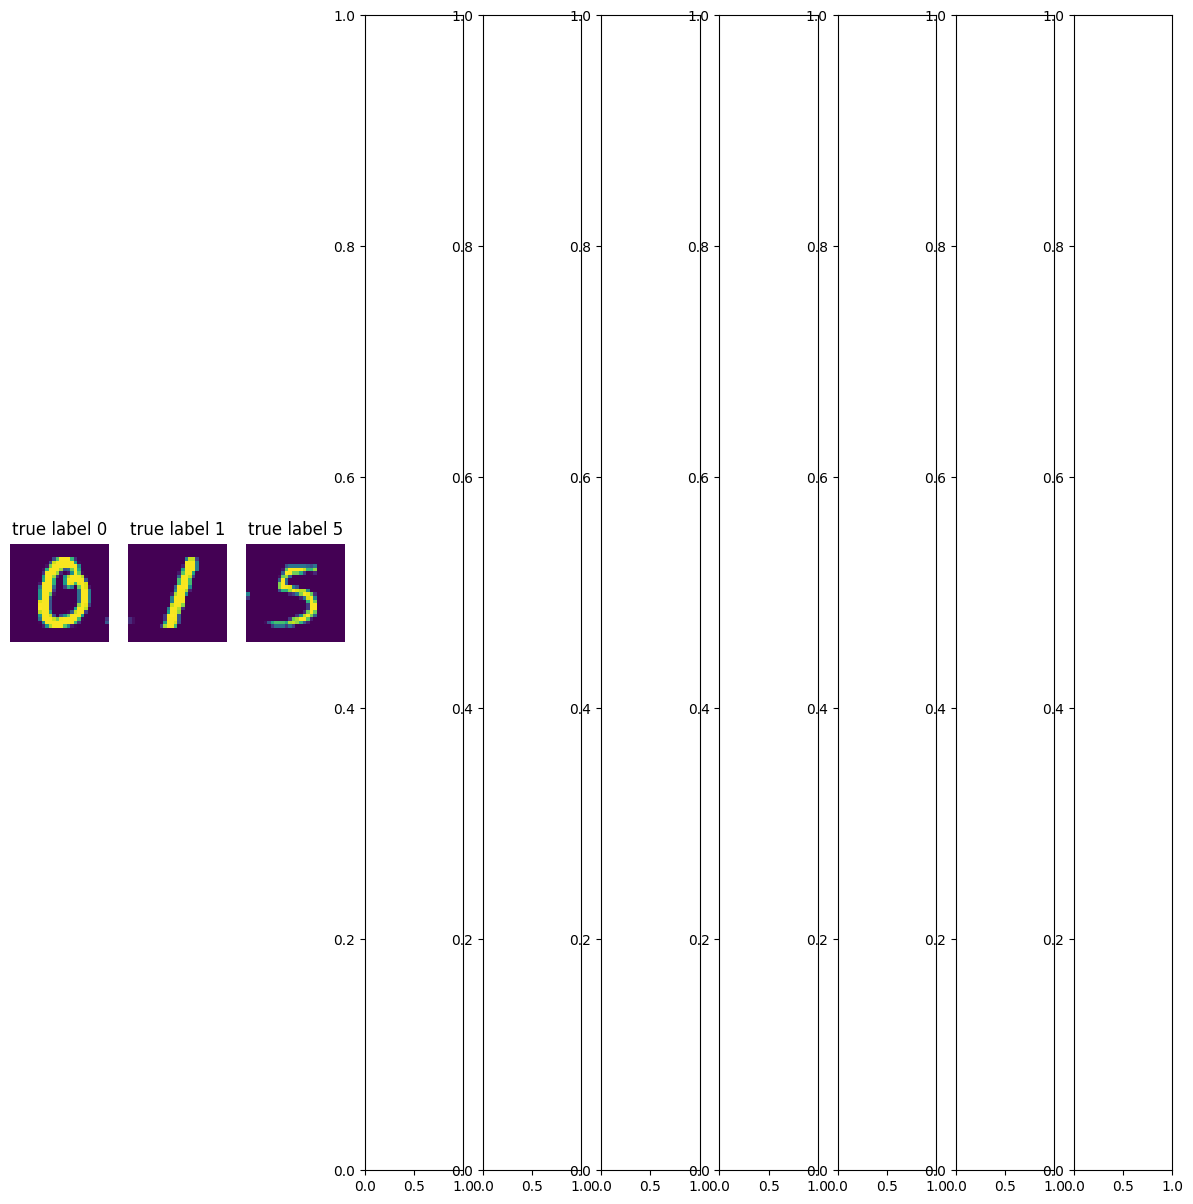

Cluster 6


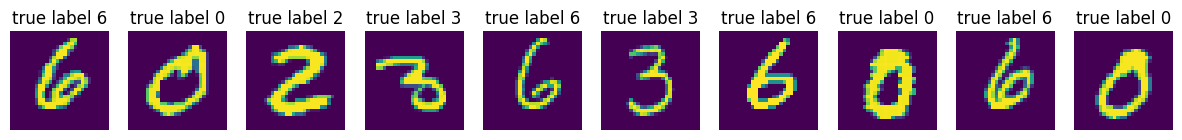

Cluster 7


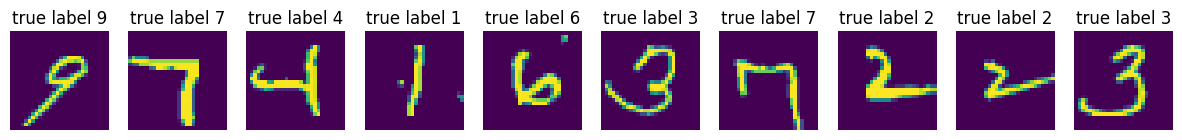

Cluster 8


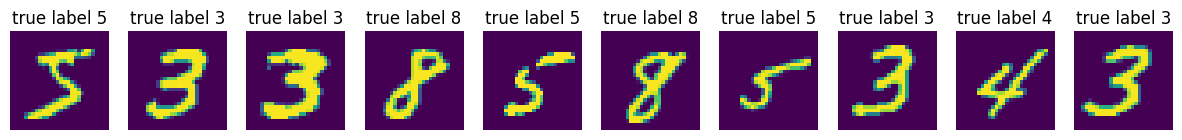

Cluster 9


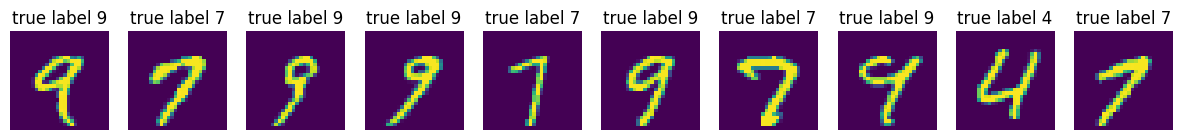

Accuracy: 27.82%
ARI is 10.57%


In [30]:
x_train_encoder_trained =  trained_model.encode(x_train_flat)
do_k_means(x_train_encoder_trained.detach().numpy())